In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
# rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/train/',
#                             transform=transform)

rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/FER2013/train_FER_labels.csv',
                            img_dir='archive/FER2013/train/',
                            transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
#                             img_dir='data/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

# rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/test/',
#                             transform=transform)

rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/FER2013/test_FER_labels.csv',
                            img_dir='archive/FER2013/test/',
                            transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
#                             img_dir='data/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [4]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [6]:
# # Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [7]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def EmotionClassifierResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = EmotionClassifierResNet18().to(device)


In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 11179590


In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 1484/1484 [01:25<00:00, 17.29it/s]


Epoch 1, Train Loss: 1.4220639497764669, Train Accuracy: 0.4188955814835095, Test Loss: 1.2469820467534887, Test Accuracy: 0.5075706594885598, Validation Loss: 1.99911546079736, Validation Accuracy: 0.3071786310517529


Epoch 2/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.51it/s]


Epoch 2, Train Loss: 1.1687932046597216, Train Accuracy: 0.5344341013436671, Test Loss: 1.1339094016340472, Test Accuracy: 0.544414535666218, Validation Loss: 2.18083087394112, Validation Accuracy: 0.3105175292153589


Epoch 3/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.58it/s]


Epoch 3, Train Loss: 1.04050554216631, Train Accuracy: 0.5918453308622215, Test Loss: 1.0931955263299007, Test Accuracy: 0.572678331090175, Validation Loss: 2.387714793807582, Validation Accuracy: 0.335559265442404


Epoch 4/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.50it/s]


Epoch 4, Train Loss: 0.9422846869076037, Train Accuracy: 0.6338823132976706, Test Loss: 1.0348907834499754, Test Accuracy: 0.5869784656796769, Validation Loss: 2.2666320424330864, Validation Accuracy: 0.34223706176961605


Epoch 5/80: 100%|██████████| 1484/1484 [01:25<00:00, 17.43it/s]


Epoch 5, Train Loss: 0.8605094374310617, Train Accuracy: 0.6666105050334864, Test Loss: 1.0069926870606278, Test Accuracy: 0.6209623149394348, Validation Loss: 1.8980668375366612, Validation Accuracy: 0.44073455759599334


Epoch 6/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.64it/s]


Epoch 6, Train Loss: 0.782818035164853, Train Accuracy: 0.702961122109431, Test Loss: 1.076511766200745, Test Accuracy: 0.5908479138627187, Validation Loss: 2.2185970889894584, Validation Accuracy: 0.38564273789649417
No improvement in validation accuracy for 1 epochs.


Epoch 7/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.65it/s]


Epoch 7, Train Loss: 0.7114864183524549, Train Accuracy: 0.7293290088875785, Test Loss: 1.0667786140155087, Test Accuracy: 0.6051480484522207, Validation Loss: 2.09931030398921, Validation Accuracy: 0.42070116861435725
No improvement in validation accuracy for 2 epochs.


Epoch 8/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.50it/s]


Epoch 8, Train Loss: 0.6345337229979167, Train Accuracy: 0.7636156859441473, Test Loss: 0.9945116372358415, Test Accuracy: 0.6463660834454913, Validation Loss: 2.547216246002599, Validation Accuracy: 0.38564273789649417
No improvement in validation accuracy for 3 epochs.


Epoch 9/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.53it/s]


Epoch 9, Train Loss: 0.5642178660695444, Train Accuracy: 0.7884672086264268, Test Loss: 1.022715997361448, Test Accuracy: 0.6374495289367429, Validation Loss: 2.7216151921372664, Validation Accuracy: 0.41402337228714525
No improvement in validation accuracy for 4 epochs.


Epoch 10/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.50it/s]


Epoch 10, Train Loss: 0.49319327204937563, Train Accuracy: 0.8222484309843731, Test Loss: 1.0861365034455253, Test Accuracy: 0.6359353970390309, Validation Loss: 2.910111897870114, Validation Accuracy: 0.3789649415692821
No improvement in validation accuracy for 5 epochs.


Epoch 11/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.50it/s]


Epoch 11, Train Loss: 0.43525279830950453, Train Accuracy: 0.8432669222020976, Test Loss: 1.1833645513748139, Test Accuracy: 0.6266823687752355, Validation Loss: 3.0093106376497367, Validation Accuracy: 0.37061769616026713
No improvement in validation accuracy for 6 epochs.


Epoch 12/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.58it/s]


Epoch 12, Train Loss: 0.38567304996788665, Train Accuracy: 0.8609999578787751, Test Loss: 1.1461294870623338, Test Accuracy: 0.6433378196500673, Validation Loss: 2.69436051971034, Validation Accuracy: 0.38731218697829717
No improvement in validation accuracy for 7 epochs.


Epoch 13/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.51it/s]


Epoch 13, Train Loss: 0.3351353814177757, Train Accuracy: 0.8826923886946633, Test Loss: 1.3066124035926756, Test Accuracy: 0.6318977119784657, Validation Loss: 2.9778648677625155, Validation Accuracy: 0.41068447412353926
No improvement in validation accuracy for 8 epochs.


Epoch 14/80: 100%|██████████| 1484/1484 [01:23<00:00, 17.69it/s]


Epoch 14, Train Loss: 0.28791268746747645, Train Accuracy: 0.9000042121224885, Test Loss: 1.2954077550838452, Test Accuracy: 0.6421601615074024, Validation Loss: 2.810009821465141, Validation Accuracy: 0.4090150250417362
No improvement in validation accuracy for 9 epochs.


Epoch 15/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.54it/s]


Epoch 15, Train Loss: 0.25832053001422806, Train Accuracy: 0.9092708815972369, Test Loss: 1.3879149651745715, Test Accuracy: 0.6110363391655451, Validation Loss: 3.261662251070926, Validation Accuracy: 0.38898163606010017
No improvement in validation accuracy for 10 epochs.


Epoch 16/80: 100%|██████████| 1484/1484 [01:24<00:00, 17.63it/s]


Epoch 16, Train Loss: 0.21999466756228206, Train Accuracy: 0.9257402805273577, Test Loss: 1.395468940247371, Test Accuracy: 0.6470390309555855, Validation Loss: 3.459968378669337, Validation Accuracy: 0.39398998330550916
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


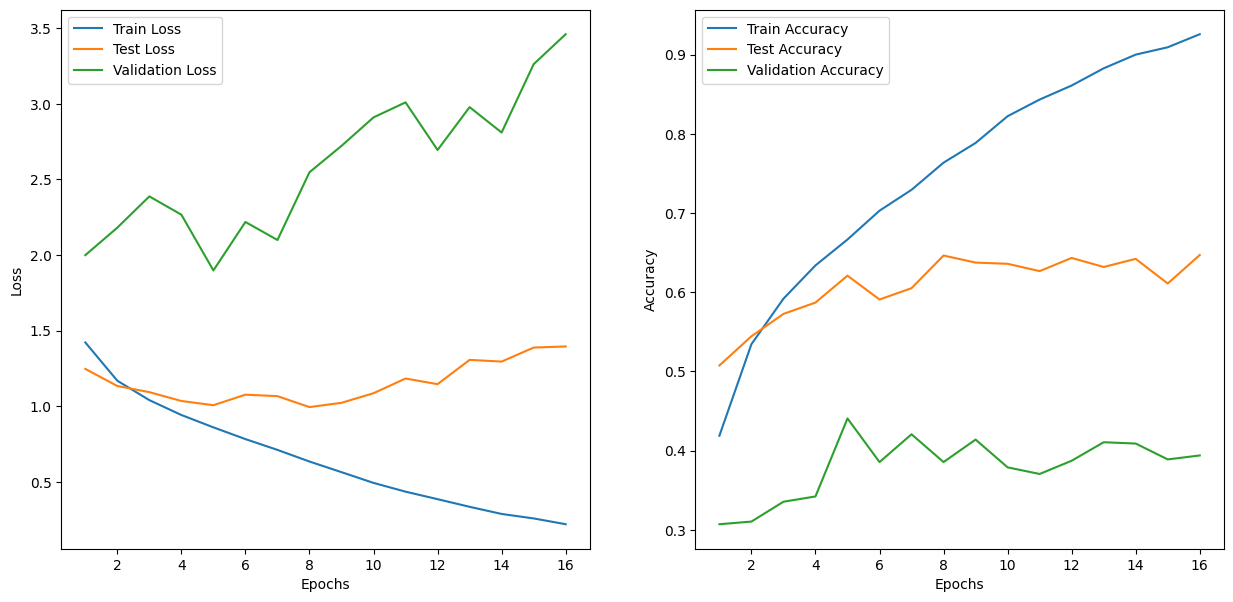

In [13]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 17), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 17), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 17), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Losses on ') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 17), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 17), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 17), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.title('Accuracies on RAF-DB') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 17), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_res18_fer.csv', index=False) # change this CSV